### Importing libs

In [186]:
from utils.data_set import get_data_json, extract_data_set_info
from utils.matrix import fix_diagonal_weight
from heuristics.closest_neighbor import closest_neighbor
from typing import Set, List, Tuple, Dict, Any
from itertools import product
import networkx as nx
import mip
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np

#### Import data set

In [187]:
try:
    data_set = get_data_json("../../data/Fortaleza/4Fortaleza_SUPB16.json")

    (num_vertices, demands, vehicle_capacity, distance_matrix) = extract_data_set_info(
        data_set
    )

    fix_diagonal_weight(distance_matrix)

    V = set(range(num_vertices))
    A = {(i, j): distance_matrix[i, j] for i in V for j in V}
    m = 4
    Q = vehicle_capacity
    q = demands
    c = distance_matrix
except Exception as e:
    raise e

2024-10-01 10:36:48.742 | SUCCESS  | utils.data_set:get_data_json:23 - JSON file loaded correctly


#### Visualize the distance matrix as a DataFrame

In [188]:
df = pd.DataFrame(c)
df

,0,1,2,3,4,5,6,7,8,9,...,39,40,41,42,43,44,45,46,47,48
0,0,5847,5711,6122,7222,7077,4668,5179,7953,6831,...,9121,9388,9482,9088,8930,10102,10516,10083,10721,11503
1,5201,0,1524,1213,2015,2530,610,1007,4065,2942,...,8332,8346,9695,6426,7195,6213,7365,7846,8199,7614
2,6032,403,0,1574,3037,2891,1013,965,3768,2645,...,8035,8049,9399,6129,6898,5916,7068,7549,7902,7317
3,6192,784,381,0,1264,1779,1394,1124,3455,2165,...,7723,7737,9086,5816,6585,5604,6588,7236,7422,6837
4,6713,1345,942,561,0,1396,1955,1685,3342,1782,...,7609,7624,8973,5703,6472,5491,6205,7123,7039,6454
5,6627,2505,2155,1774,1340,0,3115,1837,2739,386,...,7676,7523,8251,5100,5869,4887,4809,5707,5643,5058
6,4847,873,1186,1356,2996,2850,0,669,3727,2604,...,7994,8008,9358,6088,6857,5875,7027,7508,7861,7276
7,5320,902,766,1080,2325,2179,1512,0,3056,1933,...,7323,7337,8687,5417,6186,5204,6356,6837,7190,6605
8,7223,3714,3794,3290,3417,3272,4324,3046,0,3113,...,4267,4281,5631,2361,3130,2148,3217,3781,4051,3466
9,8043,3921,3323,2942,2381,2235,4531,3253,2353,0,...,7290,7136,7865,4714,5483,4501,4423,5321,5257,4672


#### Creating model instance

In [189]:
model = mip.Model(sense=mip.MINIMIZE, solver_name=mip.CBC)

#### Define binary and continuous decision variables

In [190]:
x: Dict[Tuple[int, int], mip.Var] = {
    (i, j): model.add_var(name=f"x_{i}_{j}", var_type=mip.BINARY) for (i, j) in A
}

f = {
    (i, j): model.add_var(name=f"f_{i}_{j}", var_type=mip.CONTINUOUS)
    for i in V
    for j in V
}

#### Set the objective function to minimize total distance

In [191]:
model.objective = mip.minimize(mip.xsum(cost * x[i, j] for (i, j), cost in A.items()))

#### Set the m-TSP essential constraints

In [192]:
model += mip.xsum(x[i, i] for i in V) == 0

for j in V - {0}:
    model += mip.xsum(x[i, j] for i in V) == 1  # Inflow
    model += mip.xsum(x[j, i] for i in V) == 1  # Outflow

model += mip.xsum(x[0, j] for j in V - {0}) <= m  # Vehicle limit

model += (
    mip.xsum(x[0, j] for j in V - {0}) - mip.xsum(x[j, 0] for j in V - {0}) == 0
)  # All vehicles used must return to depot

#### Add flow conservation and vehicle capacity constraints

In [193]:
model += mip.xsum(f[i, i] for i in V) == 0

for j in V - {0}:
    model += (
        mip.xsum(f[j, i] for i in V if i != j) - mip.xsum(f[i, j] for i in V if i != j)
        == q[j]
    )

for i in V:
    for j in V:
        if i != j:
            flow_lower_bound = max(0, q[i], -q[j]) * x[i, j]
            flow_upper_bound = min(Q, Q + q[i], Q - q[j]) * x[i, j]

            model += f[i, j] >= flow_lower_bound
            model += f[i, j] <= flow_upper_bound

#### Generate an initial solution using closest neighbor heuristics

In [194]:
def generate_initial_solution(
    stations: Set[int],
    demands: List[int],
    distance_matrix: np.matrix,
    vehicle_capacity: int,
    x: Dict[Tuple[int, int], mip.Var],
) -> List[Tuple[mip.Var, int]]:
    depot = 0
    customers = list(stations - {depot})
    demand_dict = dict(enumerate(demands))
    routes = closest_neighbor(
        depot, customers, demand_dict, distance_matrix, vehicle_capacity
    )

    initial_solution: List[Tuple[mip.Var, int]] = []
    for route in routes:
        for i, j in zip(route, route[1:]):
            initial_solution.append((x[i, j], 1))

    return initial_solution

In [195]:
initial_solution = generate_initial_solution(V, q, c, Q, x)

#### Implement separation procedure for subtour elimination

In [196]:
class SeparationProcedure(mip.ConstrsGenerator):
    def __init__(
        self,
        V: Set[int],
        A: Dict[Tuple[int, int], Any],
        q: List[int],
        Q: int,
        x: Dict[Tuple[int, int], mip.Var],
    ):
        self.V = V
        self.A = A
        self.x = x
        self.q = q
        self.Q = Q

    def generate_constrs(self, model: mip.Model, depth: int = 0, npass: int = 0):
        vertices = self.V
        cut_pool = mip.CutPool()
        depot = 0
        y = model.translate(self.x)

        G_prime = nx.DiGraph()
        G_prime.add_nodes_from(vertices)

        arcs_prime = [
            (i, j) for i, j in product(vertices, vertices) if i != j and y[i, j]
        ]

        for u, v in arcs_prime:
            G_prime.add_edge(u, v, capacity=y[u, v].x)

        for node in vertices - {depot}:
            flow_value, _ = nx.maximum_flow(G_prime, depot, node)

            if flow_value < 1:
                _, (S, _) = nx.minimum_cut(G_prime, depot, node)
                tour = [
                    (y[i, j], y[i, j].x)
                    for i, j in product(vertices, vertices)
                    if i != j and y[i, j] and i in S and j in S
                ]

                if sum(value for _, value in tour) >= (len(S) - 1):
                    cut = mip.xsum(1 * var for var, _ in tour) <= len(S) - 1
                    cut_pool.add(cut)

                total_demand = np.abs(sum(self.q[i] for i in S))
                min_vehicles = np.ceil(total_demand / self.Q)

                if min_vehicles < flow_value:
                    if (
                        sum(value for _, value in tour)
                        >= (len(S) - max(1, min_vehicles))
                    ):
                        stronger_cut = mip.xsum(1 * var for var, _ in tour) <= len(
                            S
                        ) - max(1, min_vehicles)
                        cut_pool.add(stronger_cut)

        for cut in cut_pool.cuts:
            model += cut

In [204]:
model.start = initial_solution
model.cuts_generator = SeparationProcedure(V, A, q, Q, x)
model.lazy_constrs_generator = SeparationProcedure(V, A, q, Q, x)
model.optimize(max_seconds=160)

Starting solution of the Linear programming relaxation problem using Dual Simplex

Clp0006I 0  Obj 105869.69 Primal inf 514.1709 (124) Dual inf 1.0232324e+14 (2312)
Clp0014I Perturbing problem by 0.001% of 0.056239088 - largest nonzero change 2.8278547e-05 ( 0.00069477173%) - largest zero change 2.9997398e-05
Clp0001I Primal infeasible - objective value 126441.66


<OptimizationStatus.INFEASIBLE: 1>

In [198]:
if model.num_solutions:
    model.check_optimization_results()

    optimal_route = [
        (origin, destination)
        for origin in V
        for destination in V
        if x[origin, destination].x == 1
    ]

    optimal_flow = [
        (origin, destination)
        for origin in V
        for destination in V
        if f[origin, destination].x and x[origin, destination].x >= 0.5
    ]

    for origin, destination in optimal_route:
        variable_name = f"x_{origin}_{destination}"
        variable_value = x[origin, destination].x
        print(f"{model.var_by_name(variable_name)} = {variable_value}")

In [199]:
print("Initial demand at each station:")
for station, demand in enumerate(q):
    print(f"Station {station}: {demand}")


Initial demand at each station:
Station 0: 0
Station 1: -6
Station 2: -4
Station 3: 1
Station 4: -1
Station 5: -4
Station 6: -3
Station 7: -4
Station 8: -3
Station 9: -5
Station 10: -1
Station 11: -5
Station 12: -5
Station 13: 0
Station 14: -3
Station 15: -7
Station 16: -8
Station 17: -3
Station 18: 0
Station 19: -3
Station 20: -7
Station 21: -3
Station 22: -5
Station 23: -6
Station 24: 0
Station 25: 0
Station 26: 1
Station 27: -4
Station 28: -2
Station 29: -2
Station 30: 2
Station 31: -4
Station 32: -2
Station 33: -1
Station 34: 1
Station 35: -2
Station 36: 0
Station 37: 2
Station 38: 2
Station 39: 0
Station 40: -1
Station 41: 0
Station 42: -1
Station 43: -6
Station 44: -2
Station 45: -3
Station 46: -1
Station 47: -2
Station 48: -3


In [200]:
print("Optimal flow between stations:")
for origin, destination in optimal_flow:
    flow_var_name = f"f_{origin}_{destination}"
    flow_value = f[origin, destination].x
    print(f"Flow from Station {origin} to Station {destination}: {flow_value}")

Optimal flow between stations:
Flow from Station 0 to Station 6: None
Flow from Station 1 to Station 9: None
Flow from Station 2 to Station 11: None
Flow from Station 3 to Station 2: None
Flow from Station 4 to Station 10: None
Flow from Station 5 to Station 7: None
Flow from Station 6 to Station 4: None
Flow from Station 7 to Station 8: None
Flow from Station 9 to Station 5: None
Flow from Station 10 to Station 3: None
Flow from Station 11 to Station 1: None
Flow from Station 12 to Station 0: None


In [201]:
def plot_route(V, route, pos=None):
    G = nx.DiGraph()
    G.add_nodes_from(V)
    G.add_edges_from(route)

    if pos is None:
        pos = nx.spring_layout(G)

    plt.figure(figsize=(12, 8))

    # Draw all nodes except 0 in light blue
    nx.draw_networkx_nodes(
        G, pos, nodelist=set(V) - {0}, node_color="lightblue", node_size=500
    )

    # Draw node 0 in red
    nx.draw_networkx_nodes(G, pos, nodelist=[0], node_color="red", node_size=500)

    nx.draw_networkx_labels(G, pos)

    # Draw edges
    nx.draw_networkx_edges(G, pos, edgelist=route, edge_color="grey", arrows=True)

    # Add edge labels (distances)
    edge_labels = {(i, j): f"{c[i,j]}" for i, j in route}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

    plt.title("Bike-sharing System Route")
    plt.axis("off")
    plt.tight_layout()
    plt.show()

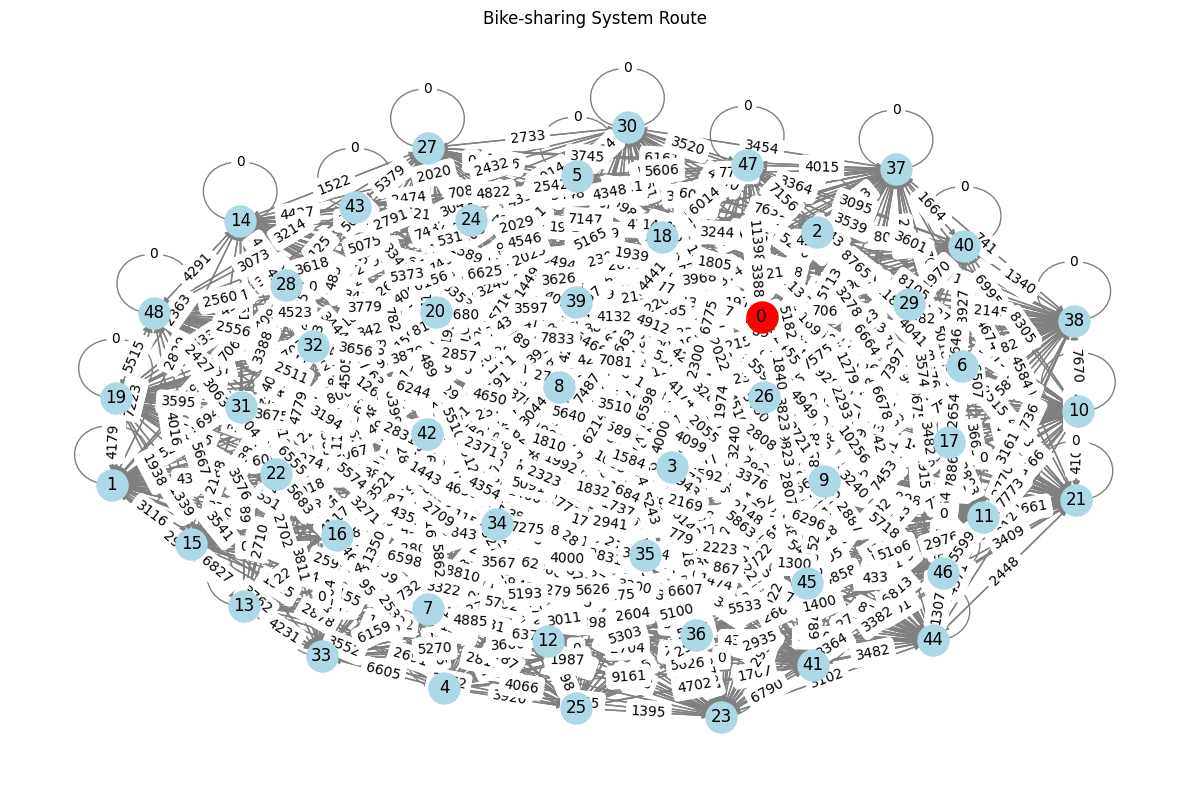

In [202]:
plot_route(V, A)

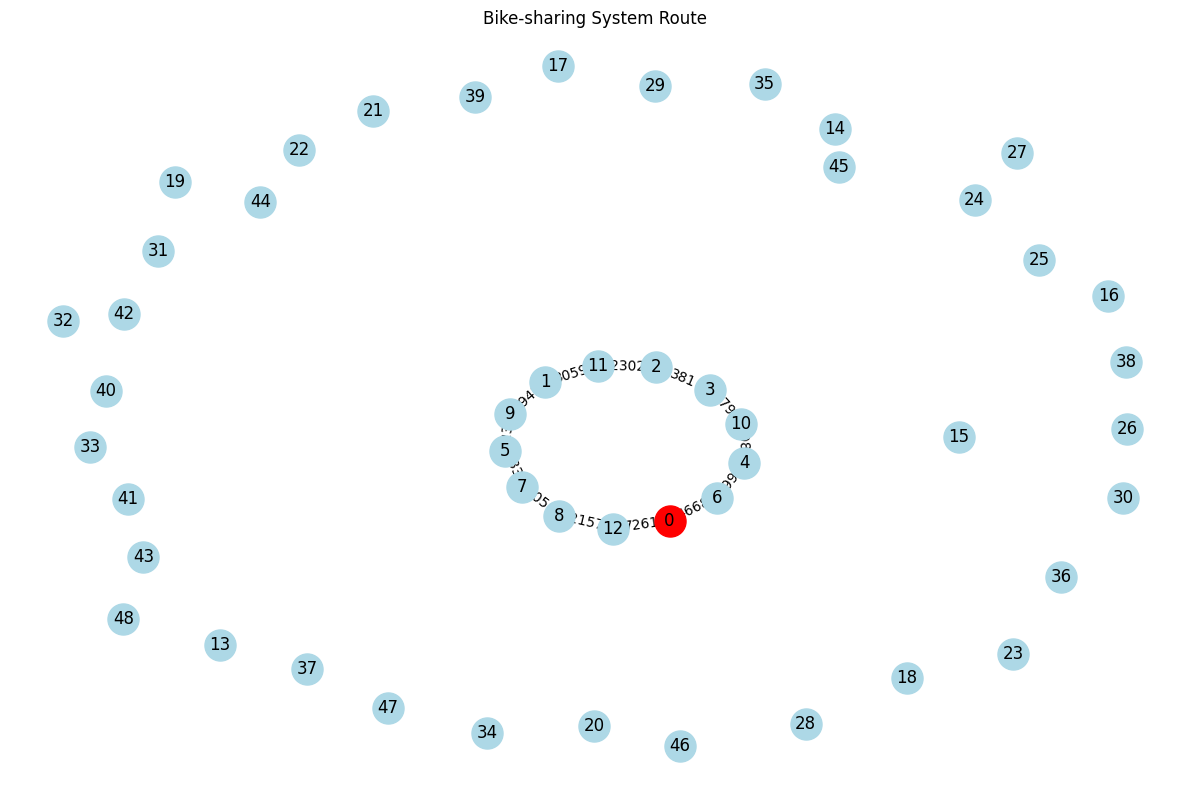

In [203]:
plot_route(V, optimal_route)